
# **[2023-1] Image Processing & Vision (55397)**

* ### Hak Gu Kim
* ### Assistant Professor
* ### Graduate School of Advanced Imaging Science, Multimedia & Film (GSAIM)
* ### Chung-Ang University
* ### Webpage: www.irislab.cau.ac.kr


# **Homework IV: Optical Flow**

* ### **Deadline:** 07 June (Wed) at 11:59pm
* ### **Submission:** Upload the zip file to "과제 및 평가" on E-class
  * **Upload zip file:** ipv23_hw04-student number.zip
    * **Python code:** ipv23_hw04-student number.ipynb
    * **Report:** ipv23_hw04-student number.pdf  (page limit: 4 pages)


## **[Homework IV-0]** Environmental Setting

In [5]:
!pip install opencv-contrib-python==4.7.0.72

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Connect to the google drive #

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
# Import the required libraries for image processing

import sys
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

dir = '/content/gdrive/My Drive/Colab Notebooks/IPV23_HW4/test imgs/'

In [2]:
# Define the functions for the load and save the input image
def loadImg(in_fname):
  img = cv2.imread(dir + in_fname)

  if img is None:
    print('Image load failed!')
    sys.exit()

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title("Input RGB Image")
  plt.show()

  return img

## Save image file
def saveImg(out_img, out_fname):
  cv2.imwrite(dir + out_fname, out_img)

## **[Homework IV]** Optical Flow Calculation
* Carefully read and understand the following optical flow code,
* Then please **complete the incomplete code:** `varable_name = [ ]`

In [3]:
##############################################
#            Image Boundary Check            #
##############################################
def inRange(cordinates, limits):
	x,y = cordinates
	X_Limit, Y_Limit = limits
	return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit


##############################################
#                Opticla Flow                #
##############################################
def opticalFlow(prev_fr, next_fr, window_size, min_quality=0.01):
    """
    opticalFlow(prev_fr, next_fr, window_size, min_quality) -> (u, v)\n
    Obtain (u,v) from Lucas Kanade's optical flow approach

    input
        prev_fr(ndarray) : previous frame image
        next_fr(ndarray) : next frame image
        window_size(int) : size of window centered in pixels
        min_quality(int) : minimum quality of corner detection
    output
        u, v(ndarray) : u, v of the optical flow constraint equation
    """

    max_corners = 10000
    min_distance = 0.1
    feature_list = cv2.goodFeaturesToTrack(prev_fr, max_corners, min_quality, min_distance)

    w = int(window_size/2)  # window range

    prev_fr = prev_fr / 255
    next_fr = next_fr / 255

    # Compute the gradients w.r.to X, Y and T dimensions
    # Solve with Sobel Edge detection
    fx = cv2.Sobel(prev_fr, cv2.CV_64F, 1, 0, ksize=5) # Gradient of x-axis
    fy = cv2.Sobel(prev_fr, cv2.CV_64F, 0, 1, ksize=5) # Gradient of y-axis
    ft = next_fr - prev_fr # Gradient of time

    u = np.zeros(prev_fr.shape)
    v = np.zeros(prev_fr.shape)

    for feature in feature_list:
        j, i = feature.ravel()	#   get cordinates of the corners (i,j). They are stored in the order j, i
        i, j = int(i), int(j)		#   i,j are floats initially

        I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
        I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
        I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

        # Set the vector A and b for Ax=b to solve the equation for optical flow
        A = np.column_stack((I_x, I_y))
        b = -I_t

        # find the x_hat vector, which is the predicted optical flow vector
        # Solve with least squares
        x_hat = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))  # Predicted u and v

        u[i,j] = x_hat[0]
        v[i,j] = x_hat[1]

    return (u, v)


##############################################
#        Functions for Visualization         #
##############################################
def drawOnFrame(frame, U, V, output_file):

    line_color = (255, 0, 0) #  Red

    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            u, v = U[i][j], V[i][j]

            if u and v:
                frame = cv2.arrowedLine(frame, (j, i), (int(round(j+u)), int(round(i+v))),
                                        (255, 0, 0), thickness=1)
    cv2.imwrite(output_file, frame)


def drawSeperately(prev_fr, next_fr, U, V, output_file):

    displacement = np.ones_like(next_fr)
    displacement.fill(255.)
    line_color =  (0, 0, 0)

    for i in range(next_fr.shape[0]):
        for j in range(next_fr.shape[1]):

            start_pixel = (j,i)
            end_pixel = (int(j+U[i][j]), int(i+V[i][j]))

            if U[i][j] and V[i][j] and inRange(end_pixel, prev_fr.shape):
                displacement = cv2.arrowedLine(displacement, start_pixel, end_pixel, line_color, thickness=2)

    figure, axes = plt.subplots(1,3)
    axes[0].imshow(prev_fr, cmap = "gray")
    axes[0].set_title("first image")
    axes[1].imshow(next_fr, cmap = "gray")
    axes[1].set_title("second image")
    axes[2].imshow(displacement, cmap = "gray")
    axes[2].set_title("displacements")
    figure.tight_layout()
    plt.savefig(output_file)


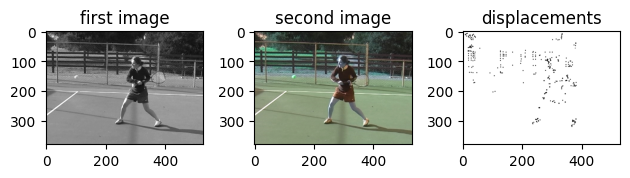

In [11]:
##############################################
#                Main Function               #
##############################################

if __name__ == "__main__":

  fname_prev = 'tennis538.jpg'
  fname_next = 'tennis539.jpg'

  prev_fr = cv2.imread(dir + fname_prev)
  next_fr = cv2.imread(dir + fname_next)

  gray_prev_fr = cv2.cvtColor(prev_fr, cv2.COLOR_RGB2GRAY)
  gray_next_fr = cv2.cvtColor(next_fr, cv2.COLOR_RGB2GRAY)

  # Obtain (u,v) from Lucas Kanade's optical flow approach
  U, V = opticalFlow(gray_prev_fr, gray_next_fr, 11, 0.1)

  # Save results
  drawSeperately(gray_prev_fr, next_fr, U, V, '/content/gdrive/My Drive/opticalflow_sep.png')
  drawOnFrame(gray_next_fr, U, V, '/content/gdrive/My Drive/opticalflow.png')
